In [2]:
import pandas as pd
import numpy as np
import os
import sys
import configparser
import matplotlib.pyplot as plt

from keras.models import Model, load_model

from sklearn.manifold import TSNE
#https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

sys.path.append(os.path.abspath('../../Module'))
import preprocessing
import evaluation
import visualize

config = configparser.ConfigParser()
config.read('../../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
input_dir = vg_json_export + 'feature_arrays/'
input_dir_raw = vg_json_export + 'raw_feature_arrays/'
output_dir = vg_json_export + 'test_combined_model/'
image_dir = config['PATHS']['vg-images']

colors = preprocessing.basic_colors()

In [3]:
model_input_dir = vg_json_export+'models/'
output_dir = vg_json_export+'prediction_arrays/'

model_file = 'earlyfusion_model.h5'
model = load_model(model_input_dir+model_file)
model.summary()

embeddings = model.layers[1].get_weights()[0]
embeddings.shape

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
td_input (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
td_embedding (Embedding)        (None, 1, 6)         5232        td_input[0][0]                   
__________________________________________________________________________________________________
bu_input (InputLayer)           (None, 512)          0                                            
________________________________________________________________________

(872, 6)

In [4]:
raw_td_arrays = np.load(vg_json_export+'raw_feature_arrays/type_to_color.npz')
raw_td_train = raw_td_arrays['train_x']
#np.concatenate((raw_td_train[:,0].reshape(-1,1), raw_td_train[:,1:].argmax(axis=1).reshape(-1,1)), axis=1)

all_obj = pd.read_csv(vg_json_export+'extracted_data/all_objects.csv', index_col=0)
objects = pd.get_dummies(
            all_obj.loc[raw_td_train[:,0]].object_name
            ).columns
objects = {i:objects[i] for i in range(len(objects))}
len(objects)

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


872

In [25]:
bottomup_arrays = np.load(vg_json_export+'prediction_arrays/results_perceptron_bgr.npz')
ids = bottomup_arrays['test_y'][:,0]

# Frequente Objekte + CDOs + CNOs:
frequent_objects, color_diagnostic_objects, color_biased_objects, color_neutral_objects = preprocessing.freq_cdo_cno(all_obj, num_cdos=100, num_cnos=100, min_num=100)
# DataFrame mit Objekten aus Prediction-Arrays
pred_obj = all_obj.loc[ids]
# DataFrames für CDOs, CBOs und CNOs
cd_obj = pred_obj.loc[pred_obj.object_name.isin(color_diagnostic_objects.keys())]
cb_obj = pred_obj.loc[pred_obj.object_name.isin(color_biased_objects)]
cn_obj = pred_obj.loc[pred_obj.object_name.isin(color_neutral_objects)]

cdo_name_list = list(cd_obj.object_name.unique())
cbo_name_list = list(cb_obj.object_name.unique())
cno_name_list = list(cn_obj.object_name.unique())

object_colors = pred_obj\
        .drop(['image_id', 'object_id', 'bb_x', 'bb_y', 'bb_w', 'bb_h'], axis=1)\
        .pivot_table(index='object_name',
                   columns='color',
                   aggfunc=len,
                   fill_value=0).idxmax(axis=1).to_dict()

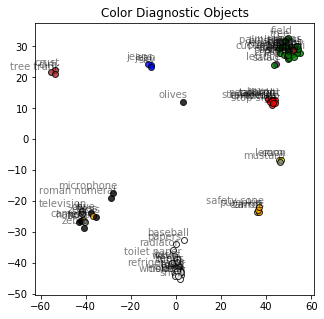

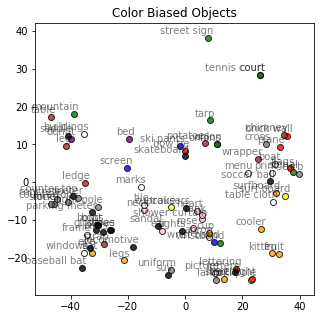

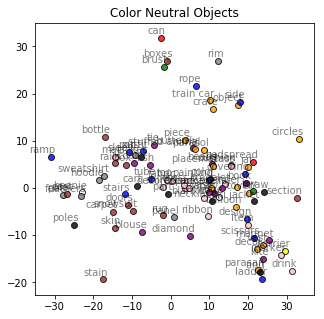

In [72]:
tsne_model = TSNE(perplexity=20, n_components=2, init='pca', n_iter=1000, random_state=123)
new_values = tsne_model.fit_transform(embeddings)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
    
# plotten

for l,title in list(zip([cdo_name_list, cbo_name_list, cno_name_list],['Color Diagnostic Objects', 'Color Biased Objects', 'Color Neutral Objects'])):
    key_list = list()
    for item  in objects.items():
        if item[1] in l:
            key_list.append(item[0])

    plt.figure(figsize=(5,5)) 
    for i in range(len(x)):
        if i in key_list:
            plt.scatter(x[i],y[i],c=object_colors[objects[i]],edgecolors='black',alpha=0.8)
            plt.annotate(objects[i],
                         xy=(x[i], y[i]),
                         xytext=(5, 2),
                         textcoords='offset points',
                         ha='right',
                         va='bottom',
                         alpha=0.5)
            plt.title(title)
    
    plt.savefig(vg_json_export+'images/'+'embeddings_'+title.replace(' ','')+'.png',bbox_inches="tight")

    plt.show()